# CNN 모델

우리의 목표: 수동 작업 대신 다양한 유형의 웨이퍼 맵 고장 패턴을 자동으로 식별하여 반도체 제작으로 웨이퍼 제조 공정의 수율을 개선할 수 있다.

데이터 : WM-811K wafer map

In [ ]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import os
from os.path import join
path = "/content/drive/MyDrive/graduation/archive"
print(os.listdir(path))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


데이터 요약

In [ ]:
df=pd.read_pickle("/content/drive/MyDrive/graduation/archive/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


데이터 세트구성


811,457 세트
1.   웨이퍼 맵
2.   웨이퍼 다이 크기
3.   로트 이름
4.   웨이퍼 인덱스 


In [ ]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


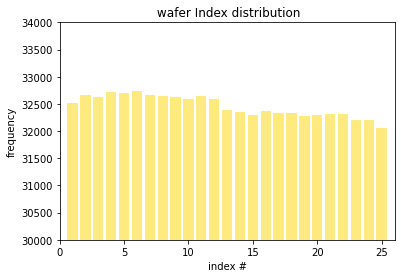

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [ ]:
df = df.drop(['waferIndex'], axis = 1)

웨이퍼 맵 컬럼에서 많은 정보는 얻지 못하지만, 각 인스턴스의 다이 크기가 다르다는 것을 알 수 있다.

웨이퍼 Map Dim 검사를 위해 

'waferMap Dim" 변수 생성.

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
208007,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot13233,[],[],"(64, 71)"
696724,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot42892,[[Training]],[[none]],"(25, 27)"
217920,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot13802,[],[],"(212, 84)"
67123,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",12552.0,lot5105,[],[],"(137, 116)"
377155,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2126.0,lot22475,[[Training]],[[Edge-Ring]],"(53, 52)"


웨이퍼 해상도(26, 26)
Footly Case 라벨로 웨이퍼 및 어레이 배열,
일부 웨이퍼 라벨은 null인데 생략함.

In [ ]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [ ]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


plot 1st data for check.

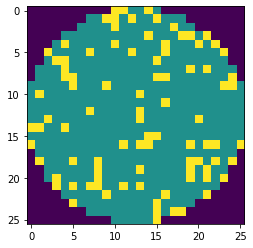

Faulty case : ['none'] 


In [ ]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

차원을 확장한 2D Convolutional Autoencoder 사용.

In [ ]:
#add channel
x = x.reshape((-1, 26, 26, 1))

불량타입목록 생성, 불량타입확인

In [ ]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


#https://blog.naver.com/oys0608/222324158962
(*참조_범주형 데이터를 칼럼으로 대체 하는 One-hot-Encoding)
웨이퍼가아니면 0 정상이면 1 오류면 2  범주형 변수

In [ ]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [ ]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

데이터 불균형 문제를 해결하기 위해 데이터 확대 필요.
웨이퍼 데이터는 이미지 데이터이므로 Convolutional Autoencoder 사용.






In [ ]:
# parameter
epoch=15
batch_size=1024

In [ ]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [ ]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

In [ ]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
15/15 - 27s - loss: 0.1557
Epoch 2/15
15/15 - 25s - loss: 0.0931
Epoch 3/15
15/15 - 25s - loss: 0.0807
Epoch 4/15
15/15 - 26s - loss: 0.0705
Epoch 5/15
15/15 - 26s - loss: 0.0622
Epoch 6/15
15/15 - 25s - loss: 0.0553
Epoch 7/15
15/15 - 26s - loss: 0.0492
Epoch 8/15
15/15 - 27s - loss: 0.0434
Epoch 9/15
15/15 - 26s - loss: 0.0376
Epoch 10/15
15/15 - 26s - loss: 0.0327
Epoch 11/15
15/15 - 26s - loss: 0.0289
Epoch 12/15
15/15 - 25s - loss: 0.0259
Epoch 13/15
15/15 - 23s - loss: 0.0235
Epoch 14/15
15/15 - 21s - loss: 0.0215
Epoch 15/15
15/15 - 23s - loss: 0.0198


오토인코더 모델 레이어의 일부로 인코더 모델 제작

In [ ]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

오토인코더 모델 레이어의 일부로 디코더 모델 제작

In [ ]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

오리지널 결함 웨이퍼 인코딩

In [ ]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

인코딩된 잠재적 결함 웨이퍼 벡터에 노이즈 추가

In [ ]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

원본 결함 웨이퍼 데이터 확인

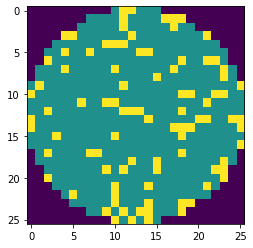

In [ ]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

신규 노이즈 결함 웨이퍼 데이터 확인

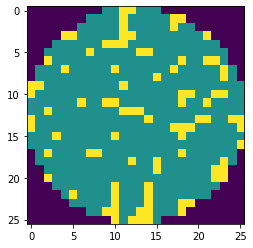

In [ ]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

재구성된 오리지널 결함 웨이퍼 데이터 확인

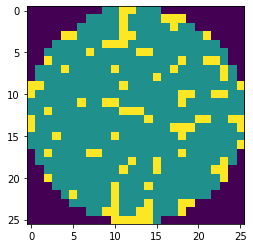

In [ ]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

각 케이스마다 2000개의 샘플이 있는 데이터로, 모든 결함있는 사례에 대한 데이터를 위와 같은 방식으로 확대 할 것이다.

In [ ]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [ ]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [ ]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [ ]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [ ]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)


In [ ]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [ ]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))


Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


Simple 2D CNN Model
웨이퍼 데이터가 이미지 이기 때문에, CNN모델을 분류에 사용한다.

모델 생성 함수를 정의하고, Sklearn교차 검증 을통해 모델을 검증 할것

In [ ]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model


K Fold Cross검증을 사용하여 CNN을 검증

K_Fold 는, K개의 fold를 만들어서 진행하는 교차검증이다.


사용이유 - 총 데이터 갯수가 적은 데이터 셋에 대하여 정확도를 향상 시킬 수 있음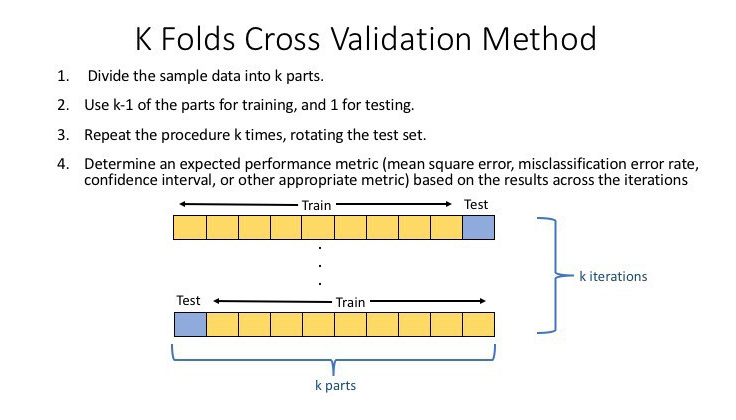


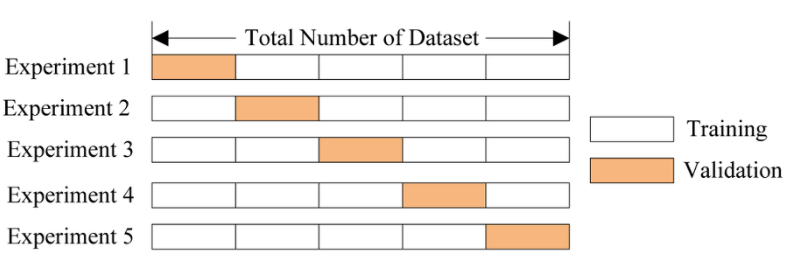

k_fold vaclidation 원리 **참조**(https://nonmeyet.tistory.com/entry/KFold-Cross-Validation%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D-%EC%A0%95%EC%9D%98-%EB%B0%8F-%EC%84%A4%EB%AA%85)

In [ ]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
9/9 - 73s - loss: 2.4772 - accuracy: 0.3221
Epoch 2/10
9/9 - 72s - loss: 1.0138 - accuracy: 0.6442
Epoch 3/10
9/9 - 69s - loss: 0.6071 - accuracy: 0.7618
Epoch 4/10
9/9 - 70s - loss: 0.4489 - accuracy: 0.8643
Epoch 5/10
9/9 - 70s - loss: 0.2712 - accuracy: 0.9214
Epoch 6/10
9/9 - 65s - loss: 0.1612 - accuracy: 0.9517
Epoch 7/10
9/9 - 65s - loss: 0.1228 - accuracy: 0.9608
Epoch 8/10
9/9 - 62s - loss: 0.8245 - accuracy: 0.8317
Epoch 9/10
9/9 - 64s - loss: 0.2880 - accuracy: 0.9335
Epoch 10/10
9/9 - 63s - loss: 0.1415 - accuracy: 0.9589
5/5 - 9s - loss: 0.1189 - accuracy: 0.9591
Epoch 1/10
9/9 - 67s - loss: 2.6219 - accuracy: 0.2178
Epoch 2/10
9/9 - 64s - loss: 1.3125 - accuracy: 0.5489
Epoch 3/10
9/9 - 64s - loss: 1.0665 - accuracy: 0.6251
Epoch 4/10
9/9 - 63s - loss: 0.7184 - accuracy: 0.7581
Epoch 5/10
9/9 - 61s - loss: 0.4624 - accuracy: 0.8369
Epoch 6/10
9/9 - 62s - loss: 0.3161 - accuracy: 0.8945
Epoch 7/10
9/9 - 64s - loss: 0.2166 - accuracy: 0.9342
Epoch 8/10
9/9 - 64s 